In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MÔ TẢ BÀI TOÁN

Giá của sản phẩm luôn thay đổi theo thị trường, thông số sản phẩm, số lượng sản phẩm, nhu cầu sản phẩm, ... Việc định giá sản phẩm để bán đối với những người bán hàng là khá khó khăn. Nó còn khó khăn hơn khi trên quy mô rất lớn vì hiện nay các ứng dụng bán hàng trực tuyến có quy mô ngày càng tăng nhanh. Ví dụ quần áo có xu hướng thay đổi mạnh về giá cả theo mùa và bị ảnh hưởng bởi nhiều thương hiệu, trong khi các đồ công nghệ chỉ dao động giá cả dựa trên thông số kỹ thuật của sản phẩm. Những công ty có phần mềm bán hàng trực tuyến, họ muốn đưa ra đề xuất về giá cho người bán, nhưng điều này rất khó vì người bán của họ được phép đưa bất kỳ thứ gì hoặc bất kỳ gói nào lên gian bán hàng của họ. Công cụ này sẽ tự động gợi ý giá sản phẩm phù hợp cho người bán hàng trực tuyến. Dựa trên các mô tả văn bản do người dùng nhập về sản phẩm của họ, bao gồm các chi tiết như tên danh mục sản phẩm, tên thương hiệu, tình trạng mặt hàng....

# PHÂN TÍCH DỮ LIỆU

Dữ liệu sẽ cung cấp cho chúng ta biết các mô tả bằng văn bản do người dùng nhập về các sản phẩm, bao gồm các chi tiết như tên danh mục sản phẩm, tên thương hiệu và tình trạng mặt hàng. Mục tiêu là xây dựng một thuật toán tự động đề xuất giá sản phẩm phù hợp. Chúng ta sẽ có hai mục tiêu để tiến đến như sau:
1. Dự đoán giá sản phẩm phù hợp dựa trên danh mục sản phẩm, tên thương hiệu, v.v...
> 1. Vấn đề cần được giải quyết là dự đoán giá hợp lệ cho các sản phẩm được bán trực tuyến. Vì vậy, đây là một vấn đề hồi quy (Regression Problem).
1. Giảm thiểu tối đa RMSLE . Tại sao lại sử dụng RMSLE?
>  Vì số lượng sản phẩm rất nhiều nên trong trường hợp dùng RMLSE, các giá trị ngoại lệ được thu nhỏ đáng kể do đó làm mất tác dụng của chúng, ngay cả khi giới thiệu ngoại lệ, lỗi RMSLE không bị ảnh hưởng nhiểu. Chúng ta có thể thấy rõ ràng rằng RMSLE rất mạnh mẽ khi các ngoại lệ xuất hiện.

Chúng ta hãy phân tích dữ liệu:
Các tệp bao gồm một danh sách các danh sách sản phẩm. Các tệp này được phân cách bằng tab.
* train_id , test_id: id của danh sách.
* name:  tiêu đề của danh sách. Lưu ý rằng chúng tôi đã làm sạch dữ liệu để xóa văn bản trông giống như giá (ví dụ:  20) để tránh rò rỉ. Các giá bị loại bỏ này được biểu thị là rm.
* item_condition_id: tình trạng của các mặt hàng do người bán cung cấp. Với 1,2,3,4,5
* category_name : thể loại của danh sách.
* brand_name: tên nhãn hiệu.
* price: giá mà mặt hàng đã được bán. Cột này không tồn tại trong test.tsv.  Đây là biến mục tiêu mà ta sẽ dự đoán. Đơn vị là USD.
* shipping: giá trị là 1 nếu phí vận chuyển do người bán thanh toán và 0 do người mua thanh toán.
* item_description: mô tả đầy đủ của item. Dữ liệu đã được làm sạch để xóa văn bản trông giống như giá (ví dụ: 20) để tránh rò rỉ. Các giá bị loại bỏ này được biểu thị là [rm]
> Ta thấy một số trường như "name" và " item_description " đang có nội dung văn bản đáng kể để làm việc. Do đó, việc coi các trường đó là các đặc điểm phân loại đơn giản và chuyển chúng thành các đặc điểm được mã hóa trên nhãn có thể không mang lại kết quả khả quan để dự đoán giá của một sản phẩm mercari. 


In [ ]:
!apt install --assume-yes p7zip-full
!7z x ../input/mercari-price-suggestion-challenge/train.tsv.7z -y
!7z x ../input/mercari-price-suggestion-challenge/test.tsv.7z -y
!7z x ../input/mercari-price-suggestion-challenge/test_stg2.tsv.zip -y
!7z x ../input/mercari-price-suggestion-challenge/sample_submission.csv.7z -y
!7z x ../input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip -y

In [ ]:
import pyximport; pyximport.install()
import gc
import time
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [ ]:
NUM_BRANDS = 3500
NUM_CATEGORIES = 800
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 40000
NUM_BOOST_ROUND_1 = 9000
NUM_BOOST_ROUND_2 = 4500

In [ ]:
#Hàm Root mean squared logarithmic errors.
def rmsle(y, y0):
     assert len(y) == len(y0)
     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [ ]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [ ]:
#Điền các giá trị NA / NaN thành missing.
def handle_missing_inplace(dataset):
    dataset['general_cat'].fillna(value='missing', inplace=True)
    dataset['subcat_1'].fillna(value='missing', inplace=True)
    dataset['subcat_2'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

In [ ]:
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category1 = dataset['general_cat'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category2 = dataset['subcat_1'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category3 = dataset['subcat_2'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
    dataset.loc[~dataset['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
    dataset.loc[~dataset['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'

In [ ]:
def to_categorical(dataset):
    dataset['general_cat'] = dataset['general_cat'].astype('category')
    dataset['subcat_1'] = dataset['subcat_1'].astype('category')
    dataset['subcat_2'] = dataset['subcat_2'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [ ]:
train = pd.read_csv("train.tsv",sep = '\t')
test = pd.read_csv("test.tsv",sep ='\t')

In [ ]:
#Xem file train gồm (hàng, cột).
train.shape

In [ ]:
# xem file test gồm (hàng, cột).
test.shape

In [ ]:
#Xem tên các cột của file train.
train.keys()

In [ ]:
#Xem tên các cột của file test.
test.keys()

In [ ]:
#Chuyển price thành dạng log rồi thêm vào file train
train['log_price'] = np.log1p(train.price)

In [ ]:
#Check lại các cột file train xem coó log_price chưa
train.keys()

In [ ]:
#Xem danh sách 60 cái đầu của train
train.head(60)

In [ ]:
#Xem tần suất xuất hiện của price
fig, axes = plt.subplots(figsize=(10,4))
#sns.distplot(train.price)
axes.hist(train.price, bins = 100, range = [min(train.price), max(train.price)+100], label = "price", color='red', alpha=0.7)
axes.set_title("Price", fontsize = 13)
axes.set_xlabel("Price", fontsize = 10)
axes.set_ylabel("Frequency ", fontsize = 10)
axes.grid()

Đầu tiên ta có thể thấy giá của sác sản phẩm phân bố chú yểu ở dưới $500

In [ ]:
#Tần suất xuất hiện của price < 500
fig, axes = plt.subplots(figsize=(10,4))
#sns.distplot(train.price)
axes.hist(train.price[train.price<500], bins = 100, range = [0,500], label = "price", color='g', alpha=0.7)
axes.set_title("Price < 500", fontsize = 13)
axes.set_xlabel("Price", fontsize = 10)
axes.set_ylabel("Frequency ", fontsize = 10)
axes.grid()

Ta vẫn thấy giá của các sản phẩm phân bố chủ yếu dưới 100$

In [ ]:
#Tần suất xuất hiện của price < $100
fig, axes = plt.subplots(figsize=(10,4))
axes.set_title('Price < 100')
axes.set_xlabel("Price", fontsize = 10)
axes.set_ylabel("Frequency ", fontsize = 10)
#sns.distplot(train.price)
axes.hist(train.price[train.price<100], bins = 100, range = [0,100], label = "price", color='blue', alpha=0.7)
axes.grid()

Chúng ta thấy rõ được sự phân bố của price. Phân phối giá lệch phải và không hoàn toàn phù hợp với Phân phối thông thường. Prie tập trung từ khoảng 0 đến 60

In [ ]:
sns.boxplot(train.price, showfliers = False, linewidth=0.7, color='red')
axes.set_title("Box Plot for Price Distribution", fontsize = 13)
axes.set_xlabel("Price", fontsize = 10)
plt.grid()

Ta thấy price tập chung từ 10 đến 29

In [ ]:
brands = train["brand_name"].value_counts()
print("No. of Unique Brand Names :", brands.size)
fig, ax = plt.subplots(1, 2, figsize = (13, 6))
# we skipped '0' index and started from 1st because 0th index has "unknown brands"
sns.barplot(brands[1:11].values, brands[1:11].index,ax = ax[0], edgecolor='k', linewidth=0.5, palette='rocket') 
ax[0].set_title("Top 10 Most Frequently Used Brand Names", fontsize = 13)
ax[0].set_xlabel("Counts", fontsize = 10)
ax[0].set_ylabel("Brand Name", fontsize = 10)

top10_brands = train.groupby('brand_name', axis=0).mean()
df_expPrice = pd.DataFrame(top10_brands.sort_values('price', ascending = False)['price'][0:10].reset_index())
ax[1].set_title("Top 10 Most Costly Brands", fontsize = 13)
ax[1] = sns.barplot(x="brand_name", y="price", data=df_expPrice, edgecolor='k', linewidth=0.5, palette='PuRd')
ax[1].set_xlabel("Brand Name", fontsize = 10)
ax[1].set_ylabel("Sale Price", fontsize = 10)
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=35)
plt.show()

Ta tìm được top 10 thương hiệu được mua nhiều nhất và top 10 thương hiệu đắt nhất.Từ đó ta có thể gợi ý giá cả theo đây? Nike là thương hiệu được sử dụng rộng rãi nhất, trong khi Demdaco là thương hiệu đắt nhất

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (13,6))
sns.countplot(train.item_condition_id, ax = ax[0], palette='Blues_r', edgecolor='k', linewidth=0.6)
rectangles = ax[0].patches
ax[0].set_title("Count Distribution of Item Condition Ids", fontsize = 13)
labels = train.item_condition_id.value_counts().values
for rect, label in zip(rectangles, labels):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2, height + 5, label, ha = "center", va = "bottom")
ax[1].set_title("Sale Price Distribution of Item Condition Ids", fontsize = 13)    
sns.boxplot(x = train.item_condition_id, y = train.price, showfliers = False, orient = "v", ax = ax[1], hue = train.shipping, palette="Set1", linewidth=0.6)
plt.show()

Số lượng sản phẩm tình trạng 1 chiém cao, tình trạng 2 với 3 ngang ngang nhau, tình trạng 4, 5 rất ít Biểu đồ hộp cho thấy xu hướng tập trung của dữ liệu (trung vị) ở mức thấp và giữa vì thế giao động lớn vừa cột 1 và 5 khoảng cách min và max lớn, các giá trị ngoại lai nhiều. item_condition_id có giá trị 1 được sử dụng rộng rãi nhất. Các sản phẩm có item_condition_ids "1" và "5" sẽ rất tốn kém. item_condition_ids có gắn cờ vận chuyển "true" đang có giá thấp hơn so với những item có gắn cờ vận chuyển "no"

In [ ]:
from wordcloud import WordCloud
import os
wordcloud = WordCloud(width = 2400, height = 1200).generate(" ".join(train.item_description.astype(str)))
plt.figure(figsize = (13, 10))
plt.imshow(wordcloud)
plt.show()

"Brand new", "free shipping", "great condition", "description", "never worn", "never used", "Victoria Secret", "smoke free", "Size large", "Size medium", "Size small", "excellent condition" là một số văn bản ở phần mô tả thường xuyên xuất hiện nhất.

In [ ]:
#Tần suất xuất hiện của log(price + 1) 
fig, axes = plt.subplots(figsize=(10,4))
axes.set_title('Log (Price + 1)')
#sns.distplot(train.price)
axes.set_xlabel("Price", fontsize = 10)
axes.set_ylabel("Frequency ", fontsize = 10)
axes.hist(train.log_price, bins = 100, range = [0,8], label = "price", color='violet', alpha=0.7)
axes.grid()

Ta thấy phân phối chuyển sang dạng log (price + 1) đang ở dạng phân phối chuẩn. Ta có thể làm nhiều thứ dựa vào đây

In [ ]:
sns.boxplot(train.log_price, showfliers = False, linewidth=0.7, color='violet')
axes.set_title("Box Plot for Price Distribution", fontsize = 13)
axes.set_xlabel("Price", fontsize = 10)
plt.grid()

Ta thấy log(price + 1) tập chung từ 2.9 đến 3.4. Từ đó suy ra sự giao động của log (price + 1) thấp hơn nhiều so với price.

In [ ]:
nrow_test = train.shape[0]
nrow_test

# MÔ TẢ THUẬT TOÁN, MÔ HÌNH ĐƯỢC CHỌN

**RIDGE REGRESSION**

**Ridge regression**
: là một phương pháp ước lượng các hệ số của mô hình hồi quy bội trong các kịch bản mà các biến độc lập có tương quan cao. Nó được sử dụng trong các lĩnh vực bao gồm kinh tế lượng, hóa học và kỹ thuật.
> Ridge regression được phát triển như một giải pháp khả thi cho việc thiếu chính xác các công cụ ước lượng bình phương nhỏ nhất khi các linear regression models có một số biến độc lập đa cộng tuyến (tương quan cao) — bằng cách tạo một ridge regression estimator (RR). Điều này cung cấp một ước tính ridge parameters chính xác hơn, vì phương sai và công cụ ước lượng bình phương trung bình của nó thường nhỏ hơn so với các công cụ ước tính bình phương nhỏ nhất có được trước đó.

**Ridge Regression** là phương pháp áp dụng khi bộ dữ liệu gặp vấn đề về đa cộng tuyến (các biến độc lập x có mối liên hệ với nhau, và ảnh hưởng lên kết quả dự báo của y), hay giải quyết các vấn đề về Overfitting mà mô hình hồi quy tuyến tính thông thường gặp phải.

> **Ví dụ:** Xe có độ tuổi là 55, mã lực bằng 100 thì có thể bán với giá là 9358 đô. Mối quan hệ giữa độ tuổi với giá trị của chiếc xe, tức là độ tuổi cao hay thấp sẽ có tác động nhất định với giá trị của chiếc xe. Nó cũng tương tự với mã lực.

**Phương trình tổng quát:** Dựa trên phương trình tổng quát của linear regression

 Y = B0 + B1X1 + B2X2 + ... + BpXp + e
 
Trong đó:
* y là biến phụ thuộc (chịu ảnh hưởng của biến x), là biến chúng ta sẽ dự báo giá trị.
* x là biến độc lập.
* B0 là giá trị ước lượng của y khi x đạt giá trị 0.
* B1,B2,... là độ dóc của đường hồi quy tuyến tính.
* e là sai số.

Chúng ta dựa vào sai số 'e'- đây là chênh lệch giữa kết quả dự báo và kết quả thực tế. Các sai số được chia thành 2 phần: Biased (thiên vị), Variance (phương sai). Trong đó:
* Biased là trường hợp mô hình phân tích không khớp, không đem lại kết quả chính xác trên tập dữ liệu training.
* Variance là đối với dữ liệu test.


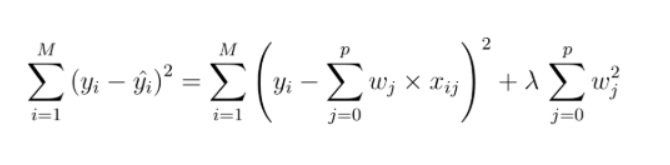

**Hệ số lambda - tham số Regularization:** là tham số luôn dương, là giá trị mà ở đó phương trình tuyến tính sẽ được "tinh chỉnh" sao cho sai số của mô hình được giảm tối đa.

**LightGBM**

**LightGBM - Light Gradient Boosting Machine**: là một khung tăng cường độ dốc sử dụng các thuật toán học tập dựa trên cây. Nó được thiết kế để phân phối và hiệu quả với những ưu điểm sau như:
* Tốc độ đào tạo nhanh hơn và hiệu quả cao hơn.
* Sử dụng bộ nhớ thấp hơn.
* Độ chính xác tốt hơn.
* Hỗ trợ học tập song song, phân tán và GPU.
* Có khả năng xử lý dữ liệu quy mô lớn.

Lấy số hàng của train

In [ ]:
#Lấy những sản phẩm có giá nhỏ hơn 1
dftt = train[(train.price < 1.0)]
dftt

In [ ]:
#Loại bỏ đi những vị trí sản phẩm có price nhỏ hơn 1
train = train.drop(train[(train.price < 1.0)].index)

In [ ]:
#Xoá bỏ đi dftt
del dftt['price']

In [ ]:
nrow_train = train.shape[0]
nrow_train

In [ ]:
#Cho y bằng giá trị của log(price)
y = np.log1p(train["price"])
y

In [ ]:
merge: pd.DataFrame = pd.concat([train, dftt, test])
submission: pd.DataFrame = test[['test_id']]

In [ ]:
del train
del test
gc.collect()

Split categories - phân chia danh mục

In [ ]:
merge['general_cat'], merge['subcat_1'], merge['subcat_2'] = \
    zip(*merge['category_name'].apply(lambda x: split_cat(x)))

In [ ]:
merge.drop('category_name', axis=1, inplace=True)

Xử lý dữ liệu còn thiếu

In [ ]:
handle_missing_inplace(merge)

Cắt dữ liệu

In [ ]:
cutting(merge)

Chuyển đổi phân loại dữ liệu

In [ ]:
to_categorical(merge)

Đếm vectorize 'name'

In [ ]:
cv = CountVectorizer(min_df=NAME_MIN_DF,ngram_range=(1, 2), stop_words='english')
cv

In [ ]:
X_name = cv.fit_transform(merge['name'])

Đếm vectorize 'categories'

In [ ]:
cv = CountVectorizer()
X_category1 = cv.fit_transform(merge['general_cat'])
X_category2 = cv.fit_transform(merge['subcat_1'])
X_category3 = cv.fit_transform(merge['subcat_2'])

In [ ]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')

In [ ]:
X_description = tv.fit_transform(merge['item_description'])

Label binarize 'brand_name'

In [ ]:
lb = LabelBinarizer(sparse_output=True)

In [ ]:
X_brand = lb.fit_transform(merge['brand_name'])

Get dummies on 'item_condition_id' và 'shipping'

In [ ]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']],sparse=True).values)

In [ ]:
X_dummies.shape,
X_description.shape,
X_brand.shape,
X_category1.shape,
X_category2.shape,
X_category3.shape,
X_name.shape

Tạo sparse merge

In [ ]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()

Train ridge

In [ ]:
X = sparse_merge[:nrow_train]
X_test = sparse_merge[nrow_test:]

In [ ]:
model = Ridge(alpha=.5, copy_X=True, fit_intercept=True, max_iter=100, normalize=False, random_state=101, solver='auto', tol=0.01)

In [ ]:
model.fit(X, y)

Predict ridge

In [ ]:
predsR = model.predict(X=X_test)

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.15, random_state = 144) 

In [ ]:
d_train = lgb.Dataset(train_X, label=train_y)
d_valid = lgb.Dataset(valid_X, label=valid_y)

In [ ]:
watchlist = [d_train, d_valid]

In [ ]:
params = {
        'learning_rate': 0.61,  #0.65,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 80, #60,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 1,
        'bagging_fraction': 0.5,
        'nthread': 4
    }

In [ ]:
params2 = {
        'learning_rate': 0.9, #0.85,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 170, #140,
        'verbosity': -1,
        'metric': 'RMSE',
        'data_random_seed': 2,
        'bagging_fraction': 1,
        'nthread': 4
    }

In [ ]:
model = lgb.train(params, train_set=d_train, num_boost_round=NUM_BOOST_ROUND_1, valid_sets=watchlist, \
    early_stopping_rounds=1000, verbose_eval=1000)

In [ ]:
predsL = model.predict(X_test)

In [ ]:
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X, y, test_size = 0.1, random_state = 101) 

In [ ]:
d_train2 = lgb.Dataset(train_X2, label=train_y2)
d_valid2 = lgb.Dataset(valid_X2, label=valid_y2)

In [ ]:
watchlist2 = [d_train2, d_valid2]

In [ ]:
model = lgb.train(params2, train_set=d_train2, num_boost_round=NUM_BOOST_ROUND_2, valid_sets=watchlist2, \
    early_stopping_rounds=500, verbose_eval=500)

In [ ]:
predsL2 = model.predict(X_test)

In [ ]:
preds = predsR*0.20 + predsL*0.4 + predsL2*0.4

In [ ]:
submission['price'] = np.expm1(preds)

In [ ]:
submission.to_csv("submission_ridge_lgb_lgb.csv", index=False)